In [1]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

In [2]:
bbb_df = pd.read_csv('adenot_processed.csv')
bbb_df

,Drug,SMILES,permeable,0,1,2,3,4,5,6,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,ACEBUTOLOL,CCCC(=O)Nc1ccc(c(c1)C(C)=O)OCC(O)CNC(C)C,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,DACTINOMYCIN,CC(C)[C@H]1NC(=O)[C@@H](NC(=O)c2ccc(c3c2N=C2C(...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,ALDOSTERONE,C[C@@]12CCC(=O)C=C2CC[C@H]2C3CC[C@H](C(=O)CO)C...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,AMILORIDE,N\C(=N)\NC(=O)c1nc(c(nc1N)N)Cl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,AMIODARONE,CCCCc1oc2ccccc2c1C(=O)c1cc(c(c(c1)[I])OCCN(CC)...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1664,THEOBROMINE,Cn1cnc2c1C(=O)NC(=O)N2C,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1665,AMITRIPTYLINE,CN(C)CCC=C1c2ccccc2CCc2ccccc12,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1666,CHLORPROMAZINE,CN(C)CCCN1c2ccccc2Sc2ccc(cc12)Cl,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1667,DISULFIRAM,CCN(CC)C(=S)SSC(=S)N(CC)CC,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [3]:
bbb_df[bbb_df['Drug'] == 'COBALAMINE']

,Drug,SMILES,permeable,0,1,2,3,4,5,6,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023


## Getting Fingerprints

In [4]:
r = 2
d = 1024

fp_list = []
for smile in bbb_df['SMILES']:
    mol = Chem.MolFromSmiles(smile)
    if mol is None:
        print('invalid SMILES')
        bbb_df = bbb_df[bbb_df['SMILES'] != smile]
    else: 
        fp = AllChem.GetMorganFingerprintAsBitVect(mol,r,nBits=d,useChirality=False)
        fp_list.append(fp)

morgan_list = np.array(fp_list)
print(morgan_list.shape)
print(bbb_df.shape)

(1669, 1024)
(1669, 1027)


## K-Means Clustering

In [5]:
k = 4
kmeans = KMeans(n_clusters=k).fit(morgan_list)
cluster_index = kmeans.predict(morgan_list)

In [6]:
count = np.bincount(cluster_index)
index = np.arange(len(count))
number = [i for i in count]
percent = [round(100*i/len(cluster_index), 2) for i in number]

cluster_df = pd.DataFrame(
    {'cluster_index': index,
    'number': number,
    'percentage': percent
    }, index = None)

cluster_df

,cluster_index,number,percentage
0,0,139,8.33
1,1,443,26.54
2,2,912,54.64
3,3,175,10.49


## Principal Component Analysis

In [7]:
dim = 100
pca = PCA(n_components=dim)
components = pca.fit_transform(morgan_list)

In [8]:
print("Overall Variance Captured by PCA-1 and PCA-2: ", sum(pca.explained_variance_ratio_[0:2]))
print("50 Principal Components Total Explained Variance: ", sum(pca.explained_variance_ratio_))
print("Fraction of Overall Variance Captured: ",  sum(pca.explained_variance_ratio_[0:2])/sum(pca.explained_variance_ratio_))

Overall Variance Captured by PCA-1 and PCA-2:  0.0968836472308993
50 Principal Components Total Explained Variance:  0.6525755063029777
Fraction of Overall Variance Captured:  0.148463505441343


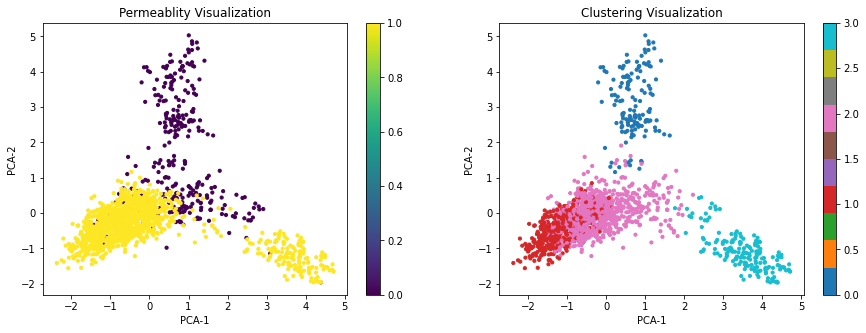

In [9]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.scatter(components[:,0], components[:,1], c=bbb_df['permeable'],s=10)
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.title('Permeablity Visualization')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(components[:,0], components[:,1], c=cluster_index,s=10, cmap='tab10')
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.title('Clustering Visualization')
plt.colorbar()

## t-SNE

In [10]:
tsne = TSNE(n_components=2)
t_components = tsne.fit_transform(components)

C:\Users\Jamie Wang\anaconda3\envs\bme590\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Jamie Wang\anaconda3\envs\bme590\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


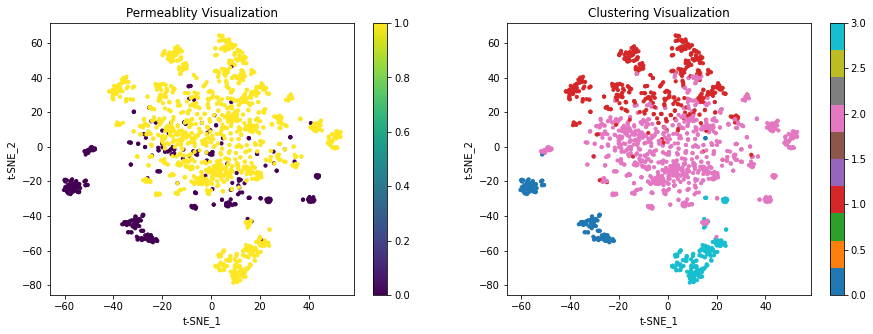

In [11]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.scatter(t_components[:,0], t_components[:,1], c=bbb_df['permeable'],s=10)
plt.xlabel('t-SNE_1')
plt.ylabel('t-SNE_2')
plt.title('Permeablity Visualization')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(t_components[:,0], t_components[:,1], c=cluster_index,s=10, cmap='tab10')
plt.xlabel('t-SNE_1')
plt.ylabel('t-SNE_2')
plt.title('Clustering Visualization')
plt.colorbar()